# WeRateDogs - Udacity Data Wrangling Project 03
---
## Gather 3 datasets from 3 different sources:
1. [Gather Data #1](#gather1) - Twitter archive, twitter-archive-enhanced.csv (local archive)
2. [Gather Data #2](#gather2) - Tweet image predictions - rt_tweets (obtained data via Twitter API, to get additional fields that coorespond to IDs in twitter_archive)
3. [Gather Data #3](#gather3) - Query Twitter API for additional data - image_preds (local archive created from image recognition system)

## 8 Quality Issues 
Also known as dirty data which includes mislabeled, corrupted, duplicated, inconsistent content issues

### twitter-archive-enhanced.csv quality issues:

1. [Quality #1](#q1) - columns 'timestamp' & 'retweeted_status_timestamp' are objects (strings) and not of 'timestamp' type

2. [Quality #2](#q2) - numerous dog names are "a"; Replace with np.NaN
   
3. [Quality #3](#q3) - doggo, floofer, pupper, & puppo use None; Replace with 0, and 1 where 'doggo, floofer, etc...' 

4. [Quality #4](#q4) - remove URL from 'source' & replace with 4 categories: iphone, vine, twitter, tweetdeck

5. [Quality #5](#q5) - remove retweets


---
## 2 Tidiness Issues
Messy data includes structural issues where variables don't form a column, observations form rows, & each observational unit forms a table.


### all 3 datasets tidiness issues:

1. [Tidy #1](#t1) - merge all 3 datasets; remove unwanted columns


### image-predictions.tsv tidiness issues:

2. Messy data - variables form both rows and columns --> p1, p2, p3, p1_conf, p2_conf, p3_conf, etc. Pivot vars into 3 cols, prediction #, prediction name, prediction probability

3. Messy data - variables from both rows and columns --> doggo, floofer, pupper, puppo. Presumably the dog should only have 1 name? If so, this issue can been resolved with imperfection (which name to select when 2 or more given). If not, and multiple 'doggo' names are allowed, then this issue becomes moot.
            

## Import Libraries

In [91]:
import pandas as pd
import numpy as np
import os
import requests

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline

## <a name="gather1">Gather Data #1 - Twitter archive</a>

In [2]:
twitterDF = pd.read_csv("data/twitter-archive-enhanced.csv")
twitterDF.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# review data columns in DF, are Dtypes appropriate, etc.
twitterDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [4]:
# review names of pups
twitterDF.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
           ... 
Brandi        1
Ronduh        1
Stuart        1
Griswold      1
Tito          1
Name: name, Length: 957, dtype: int64

In [5]:
# review dogtionary names; interesting to see id# 200 has 2 values, doggo & floofer
twitterDF[twitterDF['floofer'] != 'None'].head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,None,None
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
582,800388270626521089,NaN,NaN,2016-11-20 17:20:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Doc. He takes time out of every day to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800388270...,12,10,Doc,None,floofer,None,None


In [6]:
# it appears the designations were pulled from the tweeted text, 'doggo' & 'floofer' in text below
twitterDF.loc[200,'text']

"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"

In [7]:
# Illustrating that pup designations are NOT singular. Multiple 
twitterDF[twitterDF['doggo'] != 'None'].sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
99,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12,10,None,doggo,None,None,None
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,doggo,None,pupper,None
108,871515927908634625,NaN,NaN,2017-06-04 23:56:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,doggo,None,None,None
1079,739238157791694849,NaN,NaN,2016-06-04 23:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,None,None,None
992,748692773788876800,NaN,NaN,2016-07-01 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",That is Quizno. This is his beach. He does not...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/748692773...,10,10,his,doggo,None,None,None


## <a name="q1"> Q1 - Convert dtype of timestamp columns</a>

Q1 = Quality Item #1

In [8]:
# Fixed 2 columns with incorrect datatypes, changed to datetime64
twitterDF.timestamp = pd.to_datetime(twitterDF.timestamp)
twitterDF.retweeted_status_timestamp = pd.to_datetime(twitterDF.retweeted_status_timestamp)
twitterDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

## <a name="q2"> Q2 - dog names = 'a', replace with NaN </a>

In [9]:
# replace puppo's names that match 'a' with NaN
twitterDF.name = np.where(twitterDF.name == 'a', np.NaN, twitterDF.name)

In [10]:
# check to ensure all 'a' names were removed 
twitterDF[twitterDF.name == 'a']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


## <a name="q3"> Q3 - doggo, floofer, pupper, & puppo use None; Replace with NaN, or 0, & 1 for present </a>

In [11]:
# replace 'None' with 0
# replace 'doggo' with 1
twitterDF.doggo = np.where(twitterDF.doggo == 'None', 0, twitterDF.doggo)
twitterDF.doggo = np.where(twitterDF.doggo == 'doggo', 1, twitterDF.doggo)

In [12]:
# replace 'None' with 0
# replace 'floofer' with 1
twitterDF.floofer = np.where(twitterDF.floofer == 'None', 0, twitterDF.floofer)
twitterDF.floofer = np.where(twitterDF.floofer == 'floofer', 1, twitterDF.floofer)

In [13]:
# replace 'None' with 0
# replace 'pupper' with 1
twitterDF.pupper = np.where(twitterDF.pupper == 'None', 0, twitterDF.pupper)
twitterDF.pupper = np.where(twitterDF.pupper == 'pupper', 1, twitterDF.pupper)

In [14]:
# replace 'None' with 0
# replace 'puppo' with 1
twitterDF.puppo = np.where(twitterDF.puppo == 'None', 0, twitterDF.puppo)
twitterDF.puppo = np.where(twitterDF.puppo == 'puppo', 1, twitterDF.puppo)

In [15]:
# check to ensure cleaning successful
twitterDF[twitterDF.puppo == 'None'].count()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
dtype: int64

In [16]:
# check to ensure cleaning successful
twitterDF.query("floofer == 1")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,0,1,0,0
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/854010172...,11,10,None,1,1,0,0
582,800388270626521089,NaN,NaN,2016-11-20 17:20:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Doc. He takes time out of every day to...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/800388270...,12,10,Doc,0,1,0,0
774,776218204058357768,NaN,NaN,2016-09-15 00:36:55+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/776218204...,13,10,None,0,1,0,0
984,749317047558017024,NaN,NaN,2016-07-02 19:01:20+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Blu. He's a wild bush Floofer. I wish ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/749317047...,12,10,Blu,0,1,0,0
1022,746542875601690625,NaN,NaN,2016-06-25 03:17:46+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a golden floofer helping with the groce...,NaN,NaN,NaT,https://vine.co/v/5uZYwqmuDeT,11,10,None,0,1,0,0
1091,737445876994609152,NaN,NaN,2016-05-31 00:49:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Just wanted to share this super rare Rainbow F...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/737445876...,13,10,None,0,1,0,0
1110,733822306246479872,NaN,NaN,2016-05-21 00:50:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Moose. He's a Polynesian Floofer. Dapp...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/733822306...,10,10,Moose,0,1,0,0
1534,689993469801164801,NaN,NaN,2016-01-21 02:10:37+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a rare High Stepping Al...,NaN,NaN,NaT,https://vine.co/v/ienexVMZgi5,12,10,None,0,1,0,0
1614,685307451701334016,NaN,NaN,2016-01-08 03:50:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Petrick. He's an Altostratus Floo...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/685307451...,11,10,Petrick,0,1,0,0


## <a name="q4"> Q4 - remove URL from 'source' & replace with 4 categories: iphone, vine, twitter, tweetdeck </a>

In [17]:
# review names of sources
twitterDF.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [18]:
twitterDF.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,0,0,0


In [19]:
# function to categorize source column

def update_source(row):
    if 'iphone' in row:
        return 'iphone'
    elif 'vine' in row:
        return 'vine'
    elif 'Twitter' in row:
        return 'twitter web client'
    elif 'TweetDeck' in row:
        return 'TweetDeck'

In [20]:
# run update_source function on every row to replace source text with shorter description of source
twitterDF.source = twitterDF.apply(lambda row: update_source(row['source']),axis=1)

In [21]:
# check to ensure function replaced items as intended
twitterDF.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
950,752173152931807232,NaN,NaN,2016-07-10 16:10:29+00:00,iphone,This is Brody. He's a lifeguard. Always prepar...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/752173152...,12,10,Brody,0,0,0,0
419,822244816520155136,NaN,NaN,2017-01-20 00:50:15+00:00,iphone,We only rate dogs. Please don't send pics of m...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/822244816...,11,10,None,0,0,0,0
2330,666362758909284353,NaN,NaN,2015-11-16 21:10:36+00:00,iphone,Unique dog here. Very small. Lives in containe...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/666362758...,6,10,None,0,0,0,0
138,865718153858494464,NaN,NaN,2017-05-19 23:57:46+00:00,iphone,Meet Boomer. He's just checking pup on you. Ho...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/865718153...,13,10,Boomer,0,0,0,0
2041,671542985629241344,NaN,NaN,2015-12-01 04:14:59+00:00,iphone,"This is JD (stands for ""just dog""). He's like ...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/671542985...,10,10,JD,0,0,0,0


## <a name="q5"> Q5 - remove retweets & delete columns </a>

In [22]:
twitterDF.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1990,672640509974827008,NaN,NaN,2015-12-04 04:56:09+00:00,iphone,This is Leonidas. He just got rekt by a snowba...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/672640509...,9,10,Leonidas,0,0,0,0
2284,667192066997374976,NaN,NaN,2015-11-19 04:05:59+00:00,iphone,*takes several long deep breaths* omg omg oMG ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/667192066...,12,10,None,0,0,0,0


In [24]:
# Get indices of rows to drop, in this case, any row with a value in retweeted_status_id different that NaN.  
drop_these = twitterDF[twitterDF['retweeted_status_id'].notnull()].index
twitterDF.drop(drop_these,inplace=True)
twitterDF.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1896,674739953134403584,NaN,NaN,2015-12-09 23:58:35+00:00,iphone,"""🎶 DO YOU BELIEVE IN LIFE AFTER LOVE 🎶""\n11/10...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/674739953...,11,10,None,0,0,0,0
819,770655142660169732,NaN,NaN,2016-08-30 16:11:18+00:00,iphone,We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/770655142...,11,10,very,0,0,0,0
1537,689877686181715968,NaN,NaN,2016-01-20 18:30:32+00:00,iphone,This is Durg. He's trying to conquer his fear ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/689877686...,9,10,Durg,0,0,0,0


In [25]:
# check if any 'notnull' entries exist in retweeted_status_id
twitterDF[twitterDF['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [27]:
# get rid of 3 empty columns representing the retweeted tweets
drop_cols = ['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
twitterDF.drop(drop_cols,axis=1,inplace=True)
twitterDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   int64              
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2120 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

In [26]:
# check to ensure cols dropped
twitterDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2175 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2175 non-null   datetime64[ns, UTC]
 4   source                      2175 non-null   object             
 5   text                        2175 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns, UTC]
 9   expanded_urls               2117 non-null   object             
 10  rating_numerator            2175 non-null   int64           

In [28]:
# data exploration
# see sample of is_reply_to_status_id...
twitterDF[twitterDF.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35+00:00,iphone,@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,12,10,None,0,0,0,0
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53+00:00,iphone,@roushfenway These are good dogs but 17/10 is ...,NaN,17,10,None,0,0,0,0
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36+00:00,iphone,@RealKentMurphy 14/10 confirmed,NaN,14,10,None,0,0,0,0
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25+00:00,iphone,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,10,10,None,0,0,0,0
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35+00:00,iphone,@Jack_Septic_Eye I'd need a few more pics to p...,NaN,12,10,None,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10+00:00,iphone,After 22 minutes of careful deliberation this ...,NaN,1,10,None,0,0,0,0
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28+00:00,iphone,After countless hours of research and hundreds...,NaN,11,10,None,0,0,0,0
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30+00:00,iphone,This is Tessa. She is also very pleased after ...,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,0,0,0,0
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25+00:00,iphone,12/10 good shit Bubka\n@wane15,NaN,12,10,None,0,0,0,0


## <a name="gather2">Gather Data #2 - Tweet image predictions</a>

In [29]:
# Download data from file_url utilizing requests library & save to line#5
file_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
req = requests.get(file_url)
fname = os.path.basename(file_url)
open("data/" + fname, 'wb').write(req.content)

335079

In [30]:
# data exploration
# Nows read file downloaded & view sample
image_preds = pd.read_csv("data/image-predictions.tsv", sep="\t")
image_preds.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1821,834574053763584002,https://pbs.twimg.com/media/C5UAqgyXAAAbMWH.jpg,1,toilet_tissue,0.262936,False,golden_retriever,0.226564,True,bathtub,0.078879,False
1851,840370681858686976,https://pbs.twimg.com/media/C6mYrK0UwAANhep.jpg,1,teapot,0.981819,False,cup,0.014026,False,coffeepot,0.002421,False
701,684880619965411328,https://pbs.twimg.com/media/CYEvSaRWwAAukZ_.jpg,1,clog,0.081101,False,spindle,0.066957,False,agama,0.060884,False
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True
1542,791312159183634433,https://pbs.twimg.com/media/CvtONV4WAAAQ3Rn.jpg,4,miniature_pinscher,0.892925,True,toy_terrier,0.095524,True,Doberman,0.003544,True


In [31]:
# data exploration
image_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## <a name="gather3">Gather Data #3 - Query Twitter API for additional data</a>
Query Twitter's API for JSON data for each tweet ID in the Twitter archive

 * retweet count
 * favorite count
 * any additional data found that's interesting
 * only tweets on Aug 1st, 2017 (image predictions present)

In [ ]:
# define keys & API info 
# authenticate API using regenerated keys/tokens

consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
tweet_ids = twitterDF.tweet_id.values
len(tweet_ids)

In [32]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

NameError: name 'tweet_ids' is not defined

### Start from here if data already obtained from Twitter

In [32]:
# Read tweet JSON into dataframe using pandas
# recived ValueError: Trailing data without 'lines=True'

rt_tweets = pd.read_json("tweet.json", lines=True)
rt_tweets.head(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [33]:
# data exploration
rt_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2330 non-null   datetime64[ns, UTC]
 1   id                             2330 non-null   int64              
 2   id_str                         2330 non-null   int64              
 3   full_text                      2330 non-null   object             
 4   truncated                      2330 non-null   bool               
 5   display_text_range             2330 non-null   object             
 6   entities                       2330 non-null   object             
 7   extended_entities              2058 non-null   object             
 8   source                         2330 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

In [34]:
# data exploration
rt_tweets[rt_tweets.retweeted_status.notnull()].head(5)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
31,2017-07-15 02:45:48+00:00,886054160059072513,886054160059072512,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,False,"[0, 50]","{'hashtags': [{'text': 'BATP', 'indices': [21,...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,und,{'created_at': 'Sat Jul 15 02:44:07 +0000 2017...,8.860534e+17,8.860534e+17,"{'url': 'https://t.co/WxwJmvjfxo', 'expanded':...",NaN
35,2017-07-13 01:35:06+00:00,885311592912609280,885311592912609280,RT @dog_rates: This is Lilly. She just paralle...,False,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 830583314243268608, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,{'created_at': 'Sun Feb 12 01:04:29 +0000 2017...,NaN,NaN,NaN,NaN
67,2017-06-26 00:13:58+00:00,879130579576475649,879130579576475648,RT @dog_rates: This is Emmy. She was adopted t...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Fri Jun 23 01:10:23 +0000 2017...,NaN,NaN,NaN,NaN
72,2017-06-24 00:09:53+00:00,878404777348136964,878404777348136960,RT @dog_rates: Meet Shadow. In an attempt to r...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Fri Jun 23 16:00:04 +0000 2017...,NaN,NaN,NaN,NaN
73,2017-06-23 18:17:33+00:00,878316110768087041,878316110768087040,RT @dog_rates: Meet Terrance. He's being yelle...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,NaN,NaN,en,{'created_at': 'Tue Nov 24 03:51:38 +0000 2015...,NaN,NaN,NaN,NaN


In [35]:
# data exploration
rt_tweets.user

0       {'id': 4196983835, 'id_str': '4196983835', 'na...
1       {'id': 4196983835, 'id_str': '4196983835', 'na...
2       {'id': 4196983835, 'id_str': '4196983835', 'na...
3       {'id': 4196983835, 'id_str': '4196983835', 'na...
4       {'id': 4196983835, 'id_str': '4196983835', 'na...
                              ...                        
2325    {'id': 4196983835, 'id_str': '4196983835', 'na...
2326    {'id': 4196983835, 'id_str': '4196983835', 'na...
2327    {'id': 4196983835, 'id_str': '4196983835', 'na...
2328    {'id': 4196983835, 'id_str': '4196983835', 'na...
2329    {'id': 4196983835, 'id_str': '4196983835', 'na...
Name: user, Length: 2330, dtype: object

In [36]:
# data exploration
rt_tweets.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'quoted_status'],
      dtype='object')

In [37]:
# data exploration
# inspect the extended entities data
rt_tweets.loc[0,'extended_entities']

{'media': [{'id': 892420639486877696,
   'id_str': '892420639486877696',
   'indices': [86, 109],
   'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
   'url': 'https://t.co/MgUWQ76dJU',
   'display_url': 'pic.twitter.com/MgUWQ76dJU',
   'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
   'type': 'photo',
   'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
    'small': {'w': 540, 'h': 528, 'resize': 'fit'},
    'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}

In [38]:
# data exploration
# inspect the entities data
rt_tweets.loc[115,'entities']

{'hashtags': [],
 'symbols': [],
 'user_mentions': [],
 'urls': [],
 'media': [{'id': 869702951354474496,
   'id_str': '869702951354474496',
   'indices': [140, 163],
   'media_url': 'http://pbs.twimg.com/media/DBHOOfOXoAABKlU.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DBHOOfOXoAABKlU.jpg',
   'url': 'https://t.co/vmCu3PFCQq',
   'display_url': 'pic.twitter.com/vmCu3PFCQq',
   'expanded_url': 'https://twitter.com/dog_rates/status/869702957897576449/photo/1',
   'type': 'photo',
   'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'large': {'w': 901, 'h': 1600, 'resize': 'fit'},
    'small': {'w': 383, 'h': 680, 'resize': 'fit'},
    'medium': {'w': 676, 'h': 1200, 'resize': 'fit'}}}]}

In [39]:
# data exploration
rt_tweets.loc[130,'user']

{'id': 4196983835,
 'id_str': '4196983835',
 'name': 'WeRateDogs®',
 'screen_name': 'dog_rates',
 'location': 'merch ➜',
 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➜ WeRateDogs partnerships@weratedogs.com ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀',
 'url': 'https://t.co/N7sNNHSfPq',
 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHSfPq',
     'expanded_url': 'http://weratedogs.com',
     'display_url': 'weratedogs.com',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 8894598,
 'friends_count': 18,
 'listed_count': 6035,
 'created_at': 'Sun Nov 15 21:41:29 +0000 2015',
 'favourites_count': 145946,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 13082,
 'lang': None,
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'http://abs.twimg.com/images/them

In [40]:
# data exploration
rt_tweets.iloc[1:8,11:]

,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
1,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,5549,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,3671,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,7649,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,8249,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,2759,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,1791,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,16725,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [41]:
# keeping only records of tweets that are NOT retweeted. Should have 2167 after filtering out non-null values of retweeted_status
rt_tweets = rt_tweets[rt_tweets.retweeted_status.isnull()]
rt_tweets.sample(2)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
2106,2015-11-27 03:20:20+00:00,670079681849372674,670079681849372672,Meet Fabio. He's a wonderful pup. Can't stay a...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 670079676572950530, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN
1988,2015-12-03 01:16:17+00:00,672222792075620352,672222792075620352,This is Cal. He's a Swedish Geriatric Cheddar....,False,"[0, 127]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 672222787172442114, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [42]:
# add columns to this list for creating a new DF with only columns we want only
tweet_cols = ['created_at','id','full_text','display_text_range','retweet_count','favorite_count','user']

In [43]:
# create new DF with column defined above
rt_tweets_sub = rt_tweets.loc[:,tweet_cols]
rt_tweets_sub.head(10)

,created_at,id,full_text,display_text_range,retweet_count,favorite_count,user
0,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"[0, 85]",7477,35388,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,"[0, 138]",5549,30638,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"[0, 121]",3671,23034,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal...,"[0, 79]",7649,38689,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,2017-07-29 16:00:24+00:00,891327558926688256,This is Franklin. He would like you to stop ca...,"[0, 138]",8249,36965,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,2017-07-29 00:08:17+00:00,891087950875897856,Here we have a majestic great white breaching ...,"[0, 138]",2759,18630,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,2017-07-28 16:27:12+00:00,890971913173991426,Meet Jax. He enjoys ice cream so much he gets ...,"[0, 140]",1791,10828,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,2017-07-28 00:22:40+00:00,890729181411237888,When you watch your owner call another dog a g...,"[0, 118]",16725,59634,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,2017-07-27 16:25:51+00:00,890609185150312448,This is Zoey. She doesn't want to be one of th...,"[0, 122]",3815,25645,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,2017-07-26 15:59:51+00:00,890240255349198849,This is Cassie. She is a college pup. Studying...,"[0, 133]",6490,29261,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [44]:
rt_tweets.drop('retweeted_status',axis=1,inplace=True)
rt_tweets.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status_permalink', 'quoted_status'],
      dtype='object')

## <a name="#t1">Merge 3 datasets</a>

1. twitterDF
2. rt_tweets_sub
3. image_preds

In [45]:
# data exploration
twitterDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   int64              
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2120 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

In [46]:
# data exploration
rt_tweets_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2329
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          2167 non-null   datetime64[ns, UTC]
 1   id                  2167 non-null   int64              
 2   full_text           2167 non-null   object             
 3   display_text_range  2167 non-null   object             
 4   retweet_count       2167 non-null   int64              
 5   favorite_count      2167 non-null   int64              
 6   user                2167 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(3)
memory usage: 135.4+ KB


In [47]:
image_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [48]:
# dataframe has a different name for its shared column, id --> tweet_id
rt_tweets_sub = rt_tweets_sub.rename(columns={"id":"tweet_id"})
rt_tweets_sub.head(5)

,created_at,tweet_id,full_text,display_text_range,retweet_count,favorite_count,user
0,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"[0, 85]",7477,35388,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,"[0, 138]",5549,30638,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"[0, 121]",3671,23034,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal...,"[0, 79]",7649,38689,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,2017-07-29 16:00:24+00:00,891327558926688256,This is Franklin. He would like you to stop ca...,"[0, 138]",8249,36965,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [49]:
# MERGE 2 dataframes!
new_tweets_df = pd.merge(rt_tweets_sub, twitterDF, on='tweet_id')
new_tweets_df.head(3)

,created_at,tweet_id,full_text,display_text_range,retweet_count,favorite_count,user,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"[0, 85]",7477,35388,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-08-01 16:23:56+00:00,iphone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,0,0,0,0
1,2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,"[0, 138]",5549,30638,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-08-01 00:17:27+00:00,iphone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,0,0,0,0
2,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"[0, 121]",3671,23034,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-07-31 00:18:03+00:00,iphone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,0,0,0,0


In [50]:
# data exploration
new_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2166
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   created_at             2167 non-null   datetime64[ns, UTC]
 1   tweet_id               2167 non-null   int64              
 2   full_text              2167 non-null   object             
 3   display_text_range     2167 non-null   object             
 4   retweet_count          2167 non-null   int64              
 5   favorite_count         2167 non-null   int64              
 6   user                   2167 non-null   object             
 7   in_reply_to_status_id  78 non-null     float64            
 8   in_reply_to_user_id    78 non-null     float64            
 9   timestamp              2167 non-null   datetime64[ns, UTC]
 10  source                 2167 non-null   object             
 11  text                   2167 non-null   object           

In [51]:
# MERGE newly merged dataframe and image_preds to get new_tweets_df2
new_tweets_df2 = pd.merge(new_tweets_df, image_preds, on='tweet_id')

In [52]:
# data exploration
new_tweets_df2.head(5)

,created_at,tweet_id,full_text,display_text_range,retweet_count,favorite_count,user,in_reply_to_status_id,in_reply_to_user_id,timestamp,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,2017-08-01 16:23:56+00:00,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,"[0, 85]",7477,35388,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-08-01 16:23:56+00:00,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,2017-08-01 00:17:27+00:00,892177421306343426,This is Tilly. She's just checking pup on you....,"[0, 138]",5549,30638,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-08-01 00:17:27+00:00,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,2017-07-31 00:18:03+00:00,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,"[0, 121]",3671,23034,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-07-31 00:18:03+00:00,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,2017-07-30 15:58:51+00:00,891689557279858688,This is Darla. She commenced a snooze mid meal...,"[0, 79]",7649,38689,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-07-30 15:58:51+00:00,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,2017-07-29 16:00:24+00:00,891327558926688256,This is Franklin. He would like you to stop ca...,"[0, 138]",8249,36965,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-07-29 16:00:24+00:00,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [53]:
# data exploration
new_tweets_df2.name.isnull().count()

1986

In [88]:
# data exploration
new_tweets_df2.loc[576,'expanded_urls']

'https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1,https://twitter.com/dog_rates/status/772581559778025472/photo/1'

In [55]:
# data exploration
new_tweets_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1986 entries, 0 to 1985
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   created_at             1986 non-null   datetime64[ns, UTC]
 1   tweet_id               1986 non-null   int64              
 2   full_text              1986 non-null   object             
 3   display_text_range     1986 non-null   object             
 4   retweet_count          1986 non-null   int64              
 5   favorite_count         1986 non-null   int64              
 6   user                   1986 non-null   object             
 7   in_reply_to_status_id  23 non-null     float64            
 8   in_reply_to_user_id    23 non-null     float64            
 9   timestamp              1986 non-null   datetime64[ns, UTC]
 10  source                 1986 non-null   object             
 11  text                   1986 non-null   object           

In [57]:
count_by_name = new_tweets_df2.groupby('p1')['p1_conf'].size()

In [60]:
count_by_name.sort_values(ascending=False)

p1
golden_retriever      139
Labrador_retriever     93
Pembroke               87
Chihuahua              79
pug                    54
                     ... 
hotdog                  1
hay                     1
harp                    1
hare                    1
grey_fox                1
Name: p1_conf, Length: 374, dtype: int64

In [81]:
top10_names = count_by_name.sort_values(ascending=False).head(10)
top10_names

p1
golden_retriever      139
Labrador_retriever     93
Pembroke               87
Chihuahua              79
pug                    54
chow                   41
Samoyed                39
Pomeranian             38
toy_poodle             37
malamute               29
Name: p1_conf, dtype: int64

In [82]:
top10_names.index.values

array(['golden_retriever', 'Labrador_retriever', 'Pembroke', 'Chihuahua',
       'pug', 'chow', 'Samoyed', 'Pomeranian', 'toy_poodle', 'malamute'],
      dtype=object)

In [83]:
top10_val_array = top10_names.values

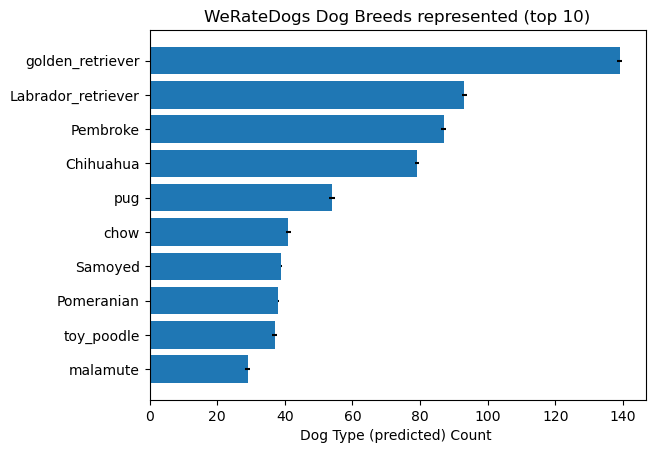

In [85]:
# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
#people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
#performance = 3 + 10 * np.random.rand(len(people))

people = top10_names.index.values 

y_pos = np.arange(len(people))

performance = top10_names.values
error = np.random.rand(len(people))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Dog Type (predicted) Count ')
ax.set_title('WeRateDogs Dog Breeds represented (top 10)')

plt.show()

In [67]:
# Data Exploration
new_tweets_df2.iloc[300:305,0:10]

,created_at,tweet_id,full_text,display_text_range,retweet_count,favorite_count,user,in_reply_to_status_id,in_reply_to_user_id,timestamp
300,2017-01-24 17:04:50+00:00,823939628516474880,This is Cash. He's officially given pup on tod...,"[0, 79]",2660,10508,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-01-24 17:04:50+00:00
301,2017-01-24 01:08:40+00:00,823699002998870016,This is Winston. The goggles make him a superh...,"[0, 135]",2481,13827,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-01-24 01:08:40+00:00
302,2017-01-23 17:20:14+00:00,823581115634085888,This is Crawford. He's quite h*ckin good at th...,"[0, 106]",2590,12889,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-01-23 17:20:14+00:00
303,2017-01-23 00:13:17+00:00,823322678127919110,This is Wyatt. He's got the fastest paws in th...,"[0, 106]",3954,15570,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-01-23 00:13:17+00:00
304,2017-01-22 01:12:59+00:00,822975315408461824,This is Albus. He's soaked as h*ck. Seems to h...,"[0, 118]",3390,17166,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,2017-01-22 01:12:59+00:00


In [68]:
# Data Exploration
new_tweets_df2.iloc[300:305,11:20]

,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
300,This is Cash. He's officially given pup on tod...,https://twitter.com/dog_rates/status/823939628...,12,10,Cash,0,0,0,0
301,This is Winston. The goggles make him a superh...,https://twitter.com/dog_rates/status/823699002...,12,10,Winston,0,0,0,0
302,This is Crawford. He's quite h*ckin good at th...,https://twitter.com/dog_rates/status/823581115...,11,10,Crawford,0,0,0,0
303,This is Wyatt. He's got the fastest paws in th...,https://twitter.com/dog_rates/status/823322678...,11,10,Wyatt,0,0,0,0
304,This is Albus. He's soaked as h*ck. Seems to h...,https://twitter.com/dog_rates/status/822975315...,12,10,Albus,0,0,0,0


In [69]:
## Data Exploration 
## Averages of doggo, floofer, pupper, & puppo. Essentially, how often have these been designated

## This means that 'doggo' was used to describe a pup 3.6% of the time

desig = ['doggo', 'floofer', 'pupper', 'puppo']

#new_tweets_df2.groupby(desig)[desig].mean()

new_tweets_df2.doggo.mean()

new_tweets_df2[desig].mean()

doggo      0.036757
floofer    0.004028
pupper     0.106747
puppo      0.011581
dtype: float64

In [70]:
## Data Exploration 
## Names most used

new_tweets_df2.name.value_counts()

None         546
Charlie       10
Cooper        10
Oliver        10
Lucy           9
            ... 
Ralf           1
Kellogg        1
Charleson      1
Betty          1
Tito           1
Name: name, Length: 933, dtype: int64

In [ ]:
top10_names.index.values

In [92]:
# Create grouping of dataframe on the first predicted name, p1, & obtained the mean of specific data points

# This one provides appropriate columns but it correctly displayed the resulting dataframe in p1 alphabetic order
# which is not statistically significant
#name_by_avgs = new_tweets_df2.groupby("p1")[['p1_conf','rating_numerator','rating_denominator','doggo','floofer','pupper','puppo','favorite_count',
#                             'retweet_count']].mean()

name_by_avgs = new_tweets_df2.groupby(top10_names.index.values)[['p1_conf','rating_numerator','rating_denominator','doggo','floofer','pupper','puppo','favorite_count',
                             'retweet_count']].mean()


name_by_avgs.head(10)

ValueError: Grouper and axis must be same length

In [71]:
name_by_avgs.index

Index(['Afghan_hound', 'African_crocodile', 'African_grey',
       'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier',
       'American_black_bear', 'Angora', 'Appenzeller', 'Arabian_camel',
       ...
       'whippet', 'white_wolf', 'wild_boar', 'window_shade',
       'wire-haired_fox_terrier', 'wombat', 'wood_rabbit', 'wooden_spoon',
       'wool', 'zebra'],
      dtype='object', name='p1', length=374)

In [72]:
name_by_avgs

,p1_conf,rating_numerator,rating_denominator,favorite_count,retweet_count
p1,,,,,
Afghan_hound,0.433959,9.666667,10.0,15432.00,5072.333333
African_crocodile,0.330625,10.000000,10.0,864.00,230.000000
African_grey,0.270468,11.000000,10.0,4729.00,1094.000000
African_hunting_dog,0.733025,8.000000,10.0,1542.00,1021.000000
Airedale,0.583771,9.833333,10.0,4716.75,1190.666667
...,...,...,...,...,...
wombat,0.697833,9.250000,10.0,6820.25,2289.500000
wood_rabbit,0.619014,10.666667,10.0,2232.00,723.666667
wooden_spoon,0.082489,12.000000,10.0,14500.00,2911.000000


In [73]:
#name_by_avgs.reset_index(inplace=True)

In [74]:
#name_by_avgs.rename(columns= {'p1':'probable_name', 'p1_conf':'probability'}, inplace=True)

In [75]:
favorites_by_name = name_by_avgs.loc[:,['favorite_count']]
favorites_by_name

,favorite_count
p1,
Afghan_hound,15432.00
African_crocodile,864.00
African_grey,4729.00
African_hunting_dog,1542.00
Airedale,4716.75
...,...
wombat,6820.25
wood_rabbit,2232.00
wooden_spoon,14500.00


In [77]:
top15_favorites = favorites_by_name.iloc[0:15,:]
top15_favorites

,favorite_count
p1,
laptop,60764.0
conch,43257.0
limousine,42614.0
Angora,42585.5
fountain,40894.0
Arabian_camel,37607.5
bubble,37330.5
orange,35388.0
beaver,34891.0


## Notable analysis from visual bar chart

### None of the top 15 favorited 'dogs' were acturately identified as dogsl

In [86]:
# create sub
favorites_by_name = name_by_avgs.loc[:,['favorite_count']]
favorites_by_name.sort_values(by=['favorite_count'], ascending=False, inplace=True)
# get top 15 of new subset to create visual from
top15_favorites = favorites_by_name.iloc[0:15,:]
group_names = top15_favorites.index
group_data = top15_favorites.favorite_count

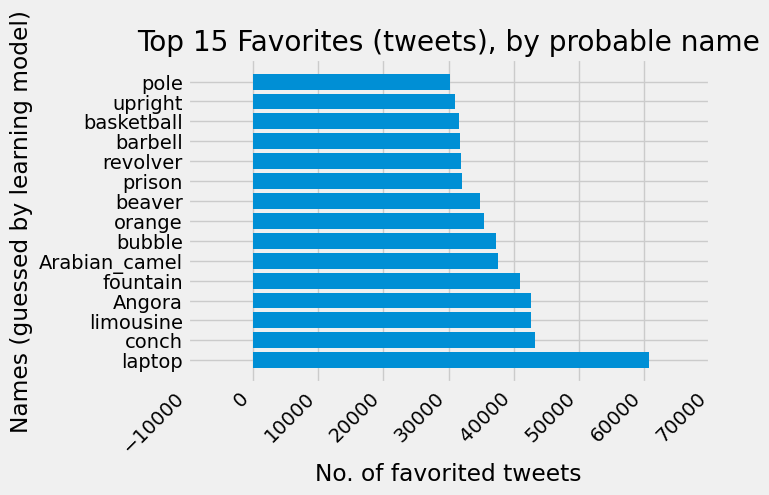

In [87]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(group_names, group_data)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[-10000, 70000], xlabel='No. of favorited tweets', ylabel='Names (guessed by learning model)',
       title='Top 15 Favorites (tweets), by probable name')

plt.show;

In [90]:
name_by_avgs

,p1_conf,rating_numerator,rating_denominator,favorite_count,retweet_count
p1,,,,,
Afghan_hound,0.433959,9.666667,10.0,15432.00,5072.333333
African_crocodile,0.330625,10.000000,10.0,864.00,230.000000
African_grey,0.270468,11.000000,10.0,4729.00,1094.000000
African_hunting_dog,0.733025,8.000000,10.0,1542.00,1021.000000
Airedale,0.583771,9.833333,10.0,4716.75,1190.666667
...,...,...,...,...,...
wombat,0.697833,9.250000,10.0,6820.25,2289.500000
wood_rabbit,0.619014,10.666667,10.0,2232.00,723.666667
wooden_spoon,0.082489,12.000000,10.0,14500.00,2911.000000


In [ ]:
# obtained directly from matplotlib examples @ 
# https://matplotlib.org/gallery/pie_and_polar_charts/bar_of_pie.html#sphx-glr-gallery-pie-and-polar-charts-bar-of-pie-py

## Attempt at Bar of Pie visualization

# make figure and assign axis objects
fig = plt.figure(figsize=(9, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

'''
# pie chart parameters
ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)
'''

# pie chart parameters


# rotate so that first wedge is split by the x-axis
angle = -180 * ratios[0]
ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
        labels=labels, explode=explode)


# bar chart parameters

xpos = 0
bottom = 0
ratios = [.33, .54, .07, .06]
width = .2
colors = [[.1, .3, .5], [.1, .3, .3], [.1, .3, .7], [.1, .3, .9]]

for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')

ax2.set_title('Age of approvers')
ax2.legend(('50-65', 'Over 65', '35-49', 'Under 35'))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
# get the wedge data
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()